In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import datetime, os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import pandas as pd
from pathlib import Path

# Unique Identifier 1
import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_dir = Path('/content/drive/MyDrive/Deep_Learning/BrainTumour/Training')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df_train = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df_train[image_df_train['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Shuffle the DataFrame and reset index
image_df_train = image_df_train.sample(frac=1).reset_index(drop = True)

# Show the result
display(image_df_train.head())
print(image_df_train.shape)
print(image_df_train['Labels'].value_counts())

,Filepaths,Labels
0,/content/drive/MyDrive/Deep_Learning/BrainTumo...,meningioma_tumor
1,/content/drive/MyDrive/Deep_Learning/BrainTumo...,pituitary_tumor
2,/content/drive/MyDrive/Deep_Learning/BrainTumo...,pituitary_tumor
3,/content/drive/MyDrive/Deep_Learning/BrainTumo...,glioma_tumor
4,/content/drive/MyDrive/Deep_Learning/BrainTumo...,meningioma_tumor


(2870, 2)
Labels
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64


In [ ]:
# Do the same for testset and merge both dataframes
image_dir = Path('/content/drive/MyDrive/Deep_Learning/BrainTumour/Testing')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

image_df_test = pd.concat([filepaths, labels], axis=1)
image_df_test = image_df_test[image_df_test['Labels'].apply(lambda x: x[-2:] != 'GT')]

image_df_test = image_df_test.sample(frac=1).reset_index(drop = True)
display(image_df_test.head())
print(image_df_test.shape)
print(image_df_test['Labels'].value_counts())

,Filepaths,Labels
0,/content/drive/MyDrive/Deep_Learning/BrainTumo...,no_tumor
1,/content/drive/MyDrive/Deep_Learning/BrainTumo...,pituitary_tumor
2,/content/drive/MyDrive/Deep_Learning/BrainTumo...,glioma_tumor
3,/content/drive/MyDrive/Deep_Learning/BrainTumo...,no_tumor
4,/content/drive/MyDrive/Deep_Learning/BrainTumo...,no_tumor


(394, 2)
Labels
meningioma_tumor    115
no_tumor            105
glioma_tumor        100
pituitary_tumor      74
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# merge both dataframes
df = pd.concat([image_df_train, image_df_test], axis=0)
df = df.reset_index(drop = True)
display(df.head())
print(df.shape)
print(df['Labels'].value_counts())

,Filepaths,Labels
0,/content/drive/MyDrive/Deep_Learning/BrainTumo...,meningioma_tumor
1,/content/drive/MyDrive/Deep_Learning/BrainTumo...,pituitary_tumor
2,/content/drive/MyDrive/Deep_Learning/BrainTumo...,pituitary_tumor
3,/content/drive/MyDrive/Deep_Learning/BrainTumo...,glioma_tumor
4,/content/drive/MyDrive/Deep_Learning/BrainTumo...,meningioma_tumor


(3264, 2)
Labels
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64


In [ ]:
import os

# Define the path to the training directory
train_dir = '/content/drive/MyDrive/Deep_Learning/BrainTumour/Training'

# Get the list of subfolders (class labels) within the training directory
class_labels = os.listdir(train_dir)

print("Class labels:", class_labels)


Class labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


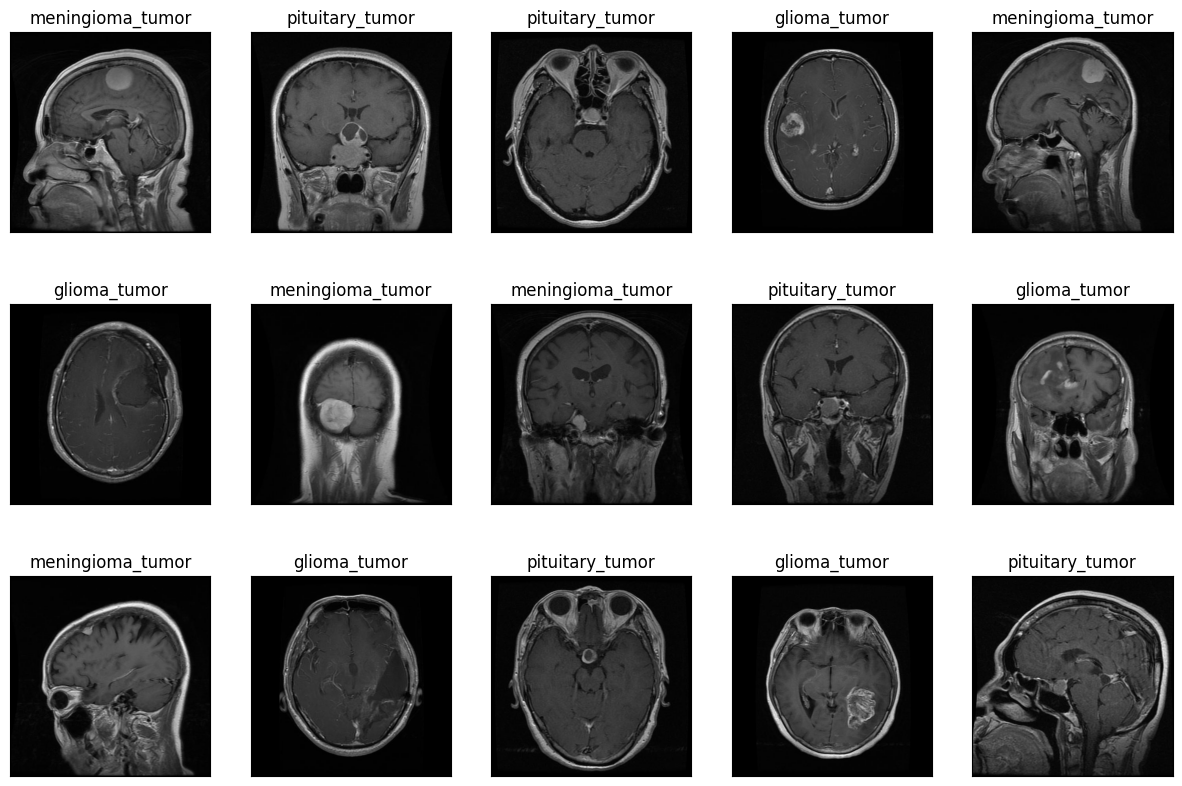

In [ ]:
#Displaying a subsample of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepaths[i]))
    ax.set_title(df.Labels[i])
plt.show()

In [ ]:
#preprocessing
import tensorflow as tf

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(df, train_size=0.85, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 2358 validated image filenames belonging to 4 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 416 validated image filenames belonging to 4 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4,
    shuffle=False
)

Found 490 validated image filenames belonging to 4 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [ ]:
#CNN
input_shape = (512, 512, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (5,5)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    x=train_images,
    validation_data=val_images,
    epochs=25,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/25
590/590 [==============================] - 386s 650ms/step - loss: 0.3124 - accuracy: 0.8944 - val_loss: 0.5557 - val_accuracy: 0.8293
Epoch 2/25
590/590 [==============================] - 398s 674ms/step - loss: 0.2324 - accuracy: 0.9122 - val_loss: 0.6042 - val_accuracy: 0.8365
Epoch 3/25
590/590 [==============================] - 392s 664ms/step - loss: 0.1958 - accuracy: 0.9360 - val_loss: 0.5654 - val_accuracy: 0.8486
Epoch 4/25
590/590 [==============================] - 379s 641ms/step - loss: 0.1264 - accuracy: 0.9550 - val_loss: 0.7265 - val_accuracy: 0.8486
Epoch 5/25
590/590 [==============================] - 377s 640ms/step - loss: 0.1415 - accuracy: 0.9521 - val_loss: 0.5234 - val_accuracy: 0.8630
Epoch 6/25
590/590 [==============================] - 378s 641ms/step - loss: 0.1212 - accuracy: 0.9623 - val_loss: 0.6850 - val_accuracy: 0.8221
Epoch 7/25
590/590 [==============================] - 399s 676ms/step - loss: 0.0753 - accuracy: 0.9758 - val_loss: 0.7670 -

In [ ]:
predictions = model.predict(x=test_images)
predictions = np.round(predictions)


123/123 [==============================] - 118s 966ms/step


In [ ]:
print(model.evaluate(test_images))

123/123 [==============================] - 22s 177ms/step - loss: 0.3899 - accuracy: 0.8816
[0.38989517092704773, 0.8816326260566711]


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_labels contain the true labels for the test data
test_labels = test_images.classes

# Assuming predictions contain the predicted labels for the test data
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(test_labels, predicted_labels, target_names=["glioma_tumor", 'meningioma_tumor', "no_tumor", "pituitary_tumor"])

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.77      0.83       145
meningioma_tumor       0.75      0.81      0.78       132
        no_tumor       0.76      0.89      0.82        73
 pituitary_tumor       0.96      0.97      0.97       140

        accuracy                           0.86       490
       macro avg       0.85      0.86      0.85       490
    weighted avg       0.86      0.86      0.86       490



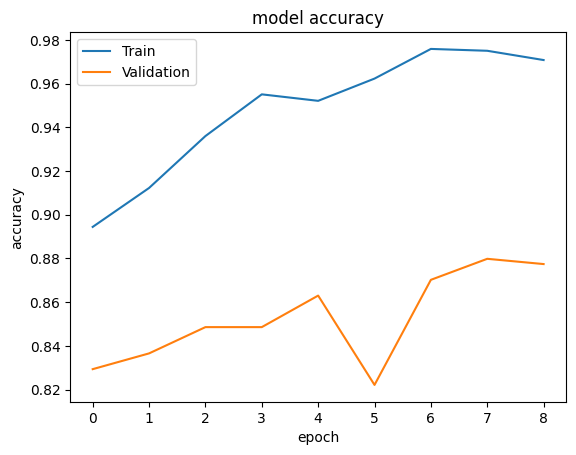

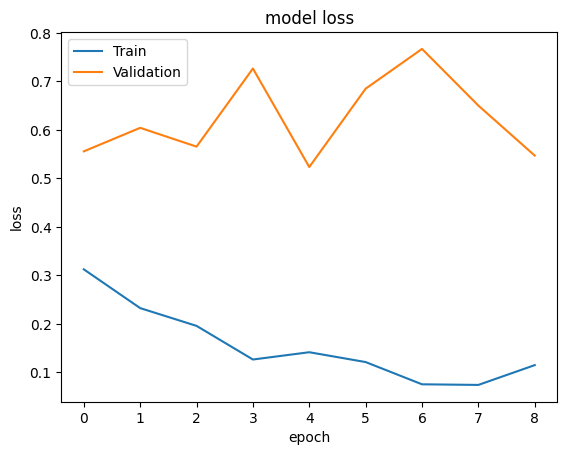

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 147ms/step
Top prediction: Tumor Found


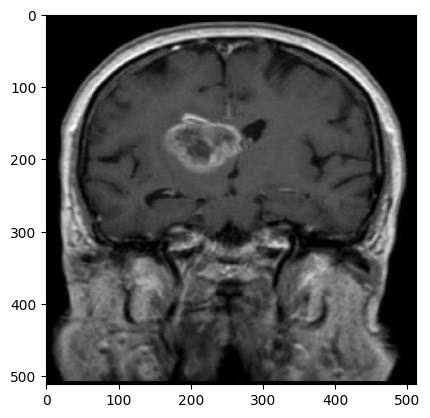

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import numpy as np

img_path = "/content/drive/MyDrive/Deep_Learning/BrainTumour/Testing/glioma_tumor/image(12).jpg"
img = image.load_img(img_path, target_size=(512, 512), color_mode='rgb')
plt.imshow(img)
img_final = image.img_to_array(img)
img_final = img_final.reshape((1, img_final.shape[0], img_final.shape[1], img_final.shape[2]))
img_final = preprocess_input(img_final)
y_pred = model.predict(img_final)
top_class_index = np.argmax(y_pred)

class_labels = {
    0: 'Tumor Found',
    1: 'Tumor Found',
    2: 'No Found',
    3: 'Tumor Found ',
}

top_class_label = class_labels[top_class_index]
print(f'Top prediction: {top_class_label}')


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def calculate_tumor_intensity_percentage(image_path, model_path):
    # Load the MRI image
    mri_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert the image to RGB
    mri_image_rgb = cv2.cvtColor(mri_image, cv2.COLOR_GRAY2RGB)

    # Resize the image to match the input size of your model
    resized_image = cv2.resize(mri_image_rgb, (512, 512))

    # Normalize pixel values to be between 0 and 1
    normalized_image = resized_image / 255.0

    # Expand dimensions to create a batch-size of 1
    input_image = np.expand_dims(normalized_image, axis=0)

    # Load the pre-trained model
    model = load_model(model_path)

    # Use the model to predict tumor probability for each class
    tumor_probabilities = model.predict(input_image)

    # Assuming tumor class is the last class (index 3)
    tumor_probability = tumor_probabilities[0, -1]

    # Calculate the intensity percentage within the tumor region
    intensity_percentage = tumor_probability * 100

    return intensity_percentage

# Example usage
image_path = '/content/drive/MyDrive/Deep_Learning/BrainTumour/Testing/glioma_tumor/image(100).jpg'
model_path = '/content/cnn.keras'

percentage = calculate_tumor_intensity_percentage(image_path, model_path)
print(f'Tumor intensity percentage: {percentage}%')


1/1 [==============================] - 0s 260ms/step
Tumor intensity percentage: 2.6267090812325478%


**VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model=VGG16(input_shape=(512,512,3),
                 include_top=False,
                 weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False
x=Flatten()(base_model.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)

x=Dense(4,activation='softmax')(x)

In [ ]:
model=tensorflow.keras.Model(base_model.input,x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
#model compile
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=train_images,
    validation_data=val_images,
    epochs=10,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
71/71 - 1126s - loss: 15.6951 - accuracy: 0.4507 - val_loss: 13.2398 - val_accuracy: 0.4400 - 1126s/epoch - 16s/step
Epoch 2/10
71/71 - 1041s - loss: 5.0335 - accuracy: 0.7359 - val_loss: 4.1600 - val_accuracy: 0.7200 - 1041s/epoch - 15s/step
Epoch 3/10
71/71 - 1042s - loss: 1.2302 - accuracy: 0.8415 - val_loss: 2.1701 - val_accuracy: 0.7800 - 1042s/epoch - 15s/step
Epoch 4/10
71/71 - 1032s - loss: 1.0748 - accuracy: 0.8732 - val_loss: 1.8575 - val_accuracy: 0.7400 - 1032s/epoch - 15s/step
Epoch 5/10
71/71 - 1015s - loss: 0.2522 - accuracy: 0.9437 - val_loss: 1.9944 - val_accuracy: 0.6600 - 1015s/epoch - 14s/step
Epoch 6/10
71/71 - 1014s - loss: 0.1167 - accuracy: 0.9683 - val_loss: 2.7312 - val_accuracy: 0.6400 - 1014s/epoch - 14s/step
Epoch 7/10
71/71 - 1026s - loss: 0.1860 - accuracy: 0.9401 - val_loss: 1.7804 - val_accuracy: 0.6800 - 1026s/epoch - 14s/step
Epoch 8/10
71/71 - 1015s - loss: 0.0848 - accuracy: 0.9718 - val_loss: 1.8994 - val_accuracy: 0.7200 - 1015s/epoch -

In [ ]:
predictions = model.predict(x=test_images)
predictions = np.round(predictions)


15/15 [==============================] - 176s 12s/step


In [ ]:
print(model.evaluate(test_images))

15/15 [==============================] - 178s 12s/step - loss: 1.1709 - accuracy: 0.7833
[1.170902132987976, 0.7833333611488342]


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_labels contain the true labels for the test data
test_labels = test_images.classes

# Assuming predictions contain the predicted labels for the test data
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(test_labels, predicted_labels, target_names=["glioma_tumor", 'meningioma_tumor', "no_tumor", "pituitary_tumor"])

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.53      0.62      0.57        13
meningioma_tumor       0.81      0.68      0.74        19
        no_tumor       0.81      0.93      0.87        14
 pituitary_tumor       1.00      0.93      0.96        14

        accuracy                           0.78        60
       macro avg       0.79      0.79      0.79        60
    weighted avg       0.80      0.78      0.79        60



**INCEPTION V3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model=InceptionV3(input_shape=(512,512,3),include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout

In [ ]:
x=Flatten()(base_model.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(4,activation='softmax')(x)

In [ ]:
model=tensorflow.keras.Model(base_model.input,x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 255, 255, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 255, 255, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 255, 255, 32)         0         ['batch_normalization[0][0

In [ ]:
#model compile
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('inceptionv3.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=train_images,
    validation_data=val_images,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
590/590 - 971s - loss: 13.7065 - accuracy: 0.6836 - val_loss: 0.6768 - val_accuracy: 0.7596 - 971s/epoch - 2s/step
Epoch 2/20
590/590 - 66s - loss: 0.6257 - accuracy: 0.7871 - val_loss: 0.6861 - val_accuracy: 0.7740 - 66s/epoch - 111ms/step
Epoch 3/20
590/590 - 89s - loss: 0.5778 - accuracy: 0.8045 - val_loss: 0.6209 - val_accuracy: 0.7957 - 89s/epoch - 151ms/step
Epoch 4/20
590/590 - 66s - loss: 0.4463 - accuracy: 0.8342 - val_loss: 0.9779 - val_accuracy: 0.7692 - 66s/epoch - 112ms/step
Epoch 5/20
590/590 - 89s - loss: 0.4366 - accuracy: 0.8312 - val_loss: 0.5735 - val_accuracy: 0.7909 - 89s/epoch - 152ms/step
Epoch 6/20
590/590 - 92s - loss: 0.7224 - accuracy: 0.7714 - val_loss: 0.4954 - val_accuracy: 0.8317 - 92s/epoch - 156ms/step
Epoch 7/20
590/590 - 66s - loss: 0.6001 - accuracy: 0.7922 - val_loss: 0.5853 - val_accuracy: 0.8149 - 66s/epoch - 111ms/step
Epoch 8/20
590/590 - 102s - loss: 0.4206 - accuracy: 0.8537 - val_loss: 0.4632 - val_accuracy: 0.8630 - 102s/epoch - 1

In [ ]:
predictions = model.predict(x=test_images)
predictions = np.round(predictions)


123/123 [==============================] - 164s 1s/step


In [ ]:
print(model.evaluate(test_images))

123/123 [==============================] - 8s 61ms/step - loss: 0.5021 - accuracy: 0.8592
[0.5021326541900635, 0.859183669090271]


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_labels contain the true labels for the test data
test_labels = test_images.classes

# Assuming predictions contain the predicted labels for the test data
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(test_labels, predicted_labels, target_names=["glioma_tumor", 'meningioma_tumor', "no_tumor", "pituitary_tumor"])

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.74      0.79       147
meningioma_tumor       0.75      0.86      0.80       133
        no_tumor       0.86      0.91      0.89        68
 pituitary_tumor       0.98      0.95      0.96       142

        accuracy                           0.86       490
       macro avg       0.86      0.87      0.86       490
    weighted avg       0.86      0.86      0.86       490



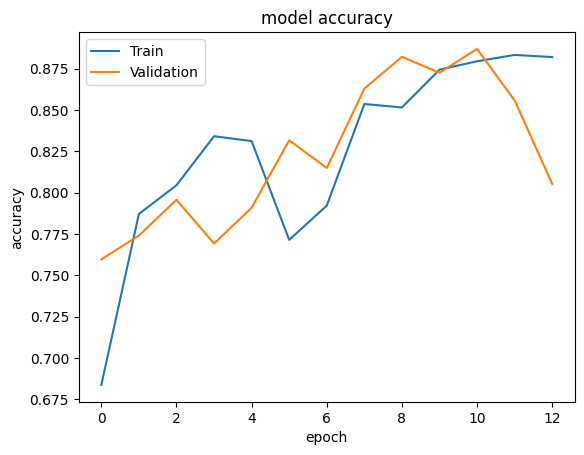

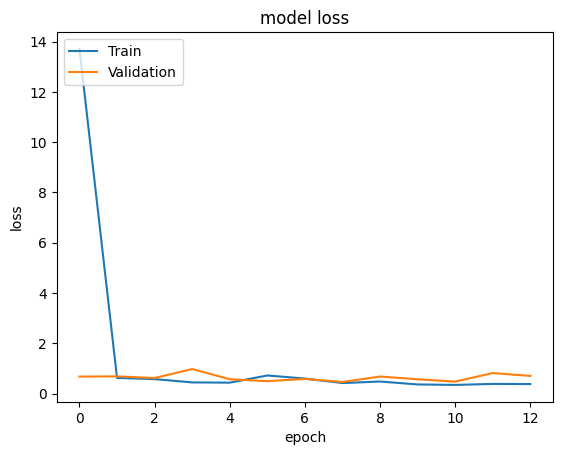

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**RESNET 50**

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model=ResNet50(input_shape=(224,224,3),include_top=False, weights='imagenet', pooling='max')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout

In [ ]:
x=Flatten()(base_model.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(4,activation='softmax')(x)

In [ ]:
model=tensorflow.keras.Model(base_model.input,x)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
#model compile
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=train_images,
    validation_data=val_images,
    epochs=15,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/15
590/590 - 60s - loss: 2.5156 - accuracy: 0.4016 - val_loss: 1.1068 - val_accuracy: 0.5361 - 60s/epoch - 102ms/step
Epoch 2/15
590/590 - 51s - loss: 1.1417 - accuracy: 0.4627 - val_loss: 1.0456 - val_accuracy: 0.5337 - 51s/epoch - 86ms/step
Epoch 3/15
590/590 - 50s - loss: 1.0819 - accuracy: 0.4953 - val_loss: 0.9593 - val_accuracy: 0.5841 - 50s/epoch - 85ms/step
Epoch 4/15
590/590 - 53s - loss: 1.0455 - accuracy: 0.5110 - val_loss: 0.9422 - val_accuracy: 0.5745 - 53s/epoch - 89ms/step
Epoch 5/15
590/590 - 50s - loss: 1.0105 - accuracy: 0.5153 - val_loss: 0.8960 - val_accuracy: 0.5745 - 50s/epoch - 85ms/step
Epoch 6/15
590/590 - 48s - loss: 0.9779 - accuracy: 0.5254 - val_loss: 0.9090 - val_accuracy: 0.5769 - 48s/epoch - 82ms/step
Epoch 7/15
590/590 - 49s - loss: 0.9901 - accuracy: 0.4958 - val_loss: 0.9117 - val_accuracy: 0.5529 - 49s/epoch - 82ms/step
Epoch 8/15
590/590 - 49s - loss: 0.9722 - accuracy: 0.5059 - val_loss: 0.8574 - val_accuracy: 0.6298 - 49s/epoch - 84ms/step

In [ ]:
predictions = model.predict(x=test_images)
predictions = np.round(predictions)


123/123 [==============================] - 10s 68ms/step
